# Try to reproduce Higher-order cyclostationary on Python.

Higher-order cyclostationary reproduction on Python.
Hi, there is a reproduction using Python. The tested signals are BPSK and QPSK with following configuration:

* Sampling rate: 1.0 Hz
* Symbol rate: 0.1 Hz
* RRC roll-off: 1.0

In [5]:
import numpy as np

# Set the alpha and beta scanning range used in RD-CTCF.
alpha = 1.
beta = 0.5

# Here I just use the full length of the sampled signal, so the following settings are not important.
full_length = True
window_size = 1024
step = 512

# the TMF function.
def TMF(s, p, q):

    L = s.shape[-1]
    ws = L if full_length else window_size

    # calculating the conjugate, and the lag product.
    m = p - q
    s = pow(s, m) * pow(np.conj(s), q)
    
    # the window time and alpha axis.
    wt = np.r_[0.:float(ws)]
    al = np.linspace(-alpha, alpha, num=int(2021))
    # the exp Calculators.
    suanzi = np.outer(np.asarray(al), np.asarray(wt))
    suanzi = np.exp(-2j*np.pi*suanzi)  # size alpha * window
    # multiplication and usual timing average function.
    s1 = np.einsum('ni,ji->nj', s, suanzi) / ws

    # second step of the multi sine wave extraction operator.
    suanzi_ = np.outer(np.asarray(wt), np.asarray(al))
    suanzi_ = np.exp(2j*np.pi*suanzi_)
    s2 = np.einsum('nj,ij->ni', s1, suanzi_)
    # normalization.
    s2 = s2 / np.sqrt(np.amax(abs(s2), axis=-1))

    return s2


def RD_CTCF(s):

    s = np.asarray(s)
    L = s.shape[-1]
    ws = L if full_length else window_size
    
    M20 = TMF(s, p=2, q=0)
    M21 = TMF(s, p=2, q=1)
    M22 = TMF(s, p=2, q=2)
    M40 = TMF(s, p=4, q=0)
    M41 = TMF(s, p=4, q=1)
    M42 = TMF(s, p=4, q=2)
    M43 = TMF(s, p=4, q=3)
    M61 = TMF(s, p=6, q=1)
    M63 = TMF(s, p=6, q=3)
    
    C40 = M40 - M20*M20 - 2*M20*M20
    C42 = M42 - abs(M20)**2 - 2*M21*M21
    C61 = M61 - 5*M21*M40 - 10*M20*M41 + 30*M20*M20*M21
    C63 = M63 - 9*M21*M42 - 3*M20*M43 - 3*M22*M41 + 18*M20*M21*M22 + 12*M21*M21*M21

    wt = np.r_[0.:float(ws)]
    al = np.linspace(-beta, beta, num=int(1011))
    
    # using the TCFs to calculate the RD=CTCF.
    suanzi = np.outer(np.asarray(al), np.asarray(wt))
    suanzi = np.exp(-2j*np.pi*suanzi)  # size alpha * window
    # using the TCFs to calculate the RD=CTCF.
    ctf40 = np.einsum('ni,ji->nj', C40, suanzi) / ws
    ctf42 = np.einsum('ni,ji->nj', C42, suanzi) / ws
    ctf61 = np.einsum('ni,ji->nj', C61, suanzi) / ws
    ctf63 = np.einsum('ni,ji->nj', C63, suanzi) / ws

    return np.stack((ctf40, ctf42, ctf61, ctf63)).transpose((1, 0, 2))


In [6]:
import h5py

# read from files, including qam2 and qam4
hf = h5py.File('my_qam_SNR_inf.h5', 'r+')
nn = []
name = []

for k in hf.keys():
    o = []
    n, l = hf[k].shape
    print (k)
    name.append(k)
    o.append(RD_CTCF(hf[k][:1, :2048]))
    nn.append(o)
    
nn = np.asarray(nn)
print (nn.shape)
hf.close()


qam_2
qam_4
(2, 1, 1, 4, 1011)


The above indicates the are two types of signal, i.e. BPSK and QPSK

(2, 1, 1, 4, 1011) \
2 means 2 signal types. \
4 means RD CTCF (40/42/61/63) \
1011 means the length of alpha axis


qam_2 C40


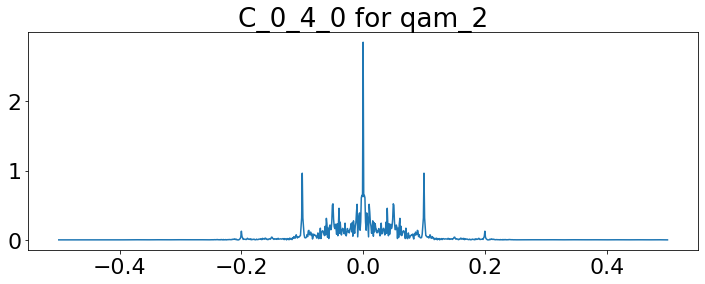

qam_2 C42


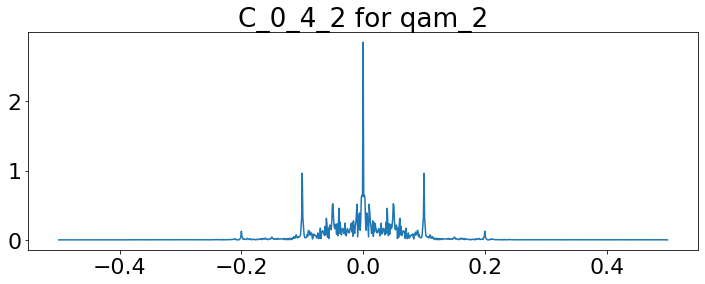

qam_2 C61


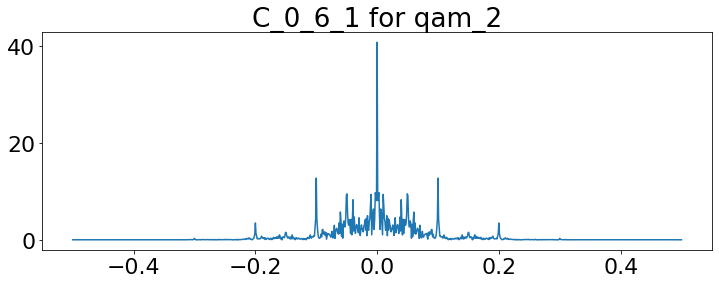

qam_2 C63


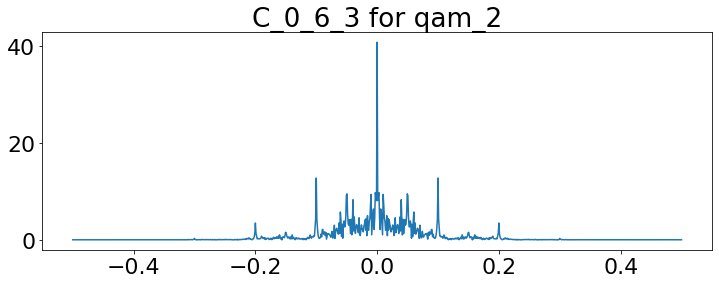

qam_4 C40


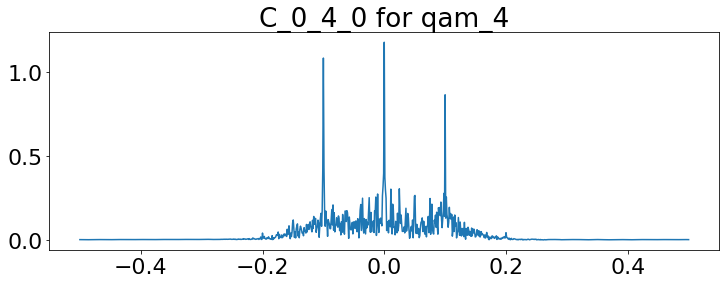

qam_4 C42


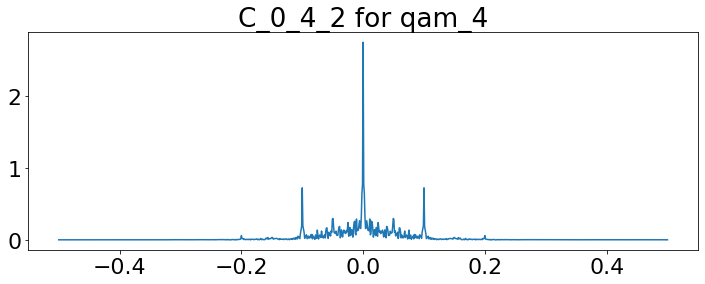

qam_4 C61


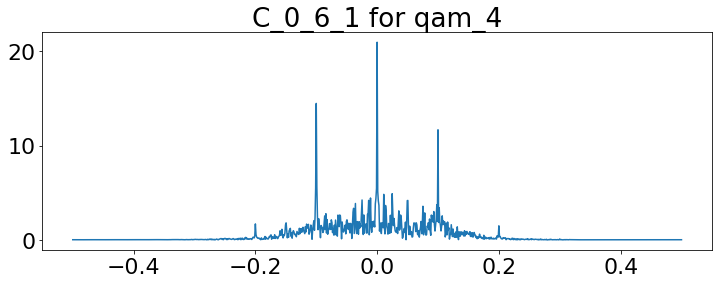

qam_4 C63


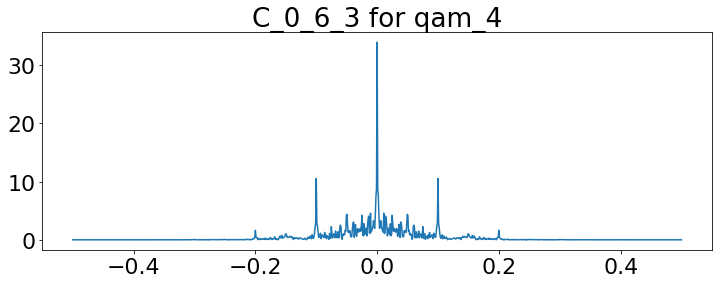

In [7]:
#%matplotlib notebook
import h5py, pickle
import numpy as np
import numpy
import matplotlib.pyplot as plt


x_ticks = np.linspace(-beta, beta, num=int(nn.shape[-1]))

para = {'figure.figsize' : (12, 4), 
        'font.size'      : 22    }

plt.rcParams.update(para)

for i in range(nn.shape[0]):
    
    print (name[i], 'C40')
    plt.title(f'C_0_4_0 for {name[i]}')
    #plt.ylim(0.0, 1.5)
    plt.plot(x_ticks, abs(nn[i, 0, 0, 0, :]))
    plt.show()
    
    print (name[i], 'C42')
    #plt.ylim(0.0, 1.5)
    plt.title(f'C_0_4_2 for {name[i]}')
    plt.plot(x_ticks, abs(nn[i, 0, 0, 1, :]))
    plt.show()
    
    print (name[i], 'C61')
    plt.title(f'C_0_6_1 for {name[i]}')
    #plt.ylim(0.0, 5.)
    plt.plot(x_ticks, abs(nn[i, 0, 0, 2, :]))
    plt.show()
    
    print (name[i], 'C63')    
    plt.title(f'C_0_6_3 for {name[i]}')
    #plt.ylim(0.0, 5.)
    plt.plot(x_ticks, abs(nn[i, 0, 0, 3, :]))
    plt.show()

hf.close()


## Currently I have some confusions when verifying every detail to reproduce the high order cumulants.

The tested signals are BPSK and QPSK with following configuration:

* Sampling rate: 1.0 Hz
* Symbol rate: 0.1 Hz
* RRC roll-off: 1.0

According to the above figures, it can be seen that there are reasonable peaks at the corresponding $\alpha$ positions, for example, at $\alpha= 0.0, \pm 0.1, \pm 0.2 $ etc.. 

* But for bpsk, as shown above, there are small side peaks appears in the interval [0.0, 0.1] that I do not understand. I guess maybe this is related to my settings of the RRC filter?

* In the $TMF()$ function (defined in the very beginning of this page), I try to carry out the $\left< \prod_{j=1}^{n} x(t+\tau_j) \right>$, it’s okay to compute the $\prod_{j=1}^{n} x(t+\tau_j)$, but I am little bit confused how to do the $\left< \cdot \right>$ operator.

    For a discrete and finite length of sampled signal, does this mean that the output of the *multiple sine-wave extraction operation* is the same as the input at this point? Because for a discrete signal of finite length, after the time-averaging of $x(u)e^{-j2\pi\alpha u}$, then multiplied by $e^{j2\pi\alpha t}$, and at last summing over the $\alpha$, does this come back to itself?
    
* Also, I'm little curious which blog the header image of your blog comes from? I only found similar pictures in link : https://cyclostationary.blog/2015/11/05/introduction-to-higher-order-cyclostationarity/
    
    But I did not find the source of these classic images:
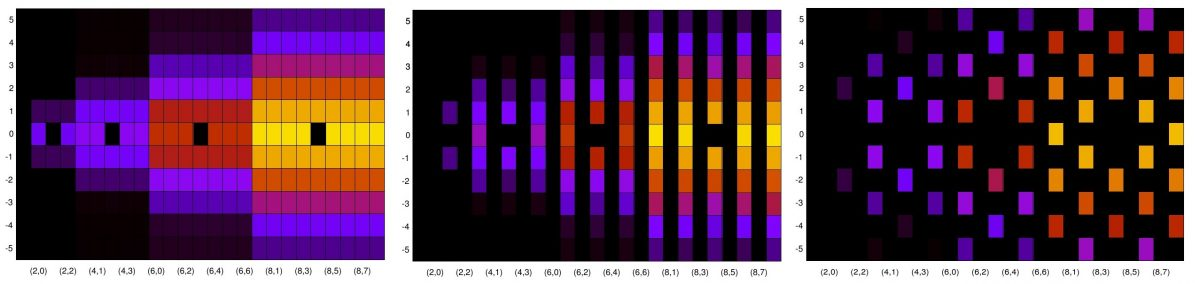
 
    And, for the "Tetris" plot of bpsk or qpsk, the main peak should not be missing in the middle, or are these plots of other modulation modes? Or are these images considering the case where $\mathbf{\tau} \neq \mathbf{0}$ ?
    
   
Thank you very much if you can help me with these questions!